# Identificação e Validação do modelo linear da taxa p(t)

Os dados de entrada correspondem à resposta em frequência obtidos com o script `analise_resposta_em_freq.ipynb`.
Será analisada a taxa `p` variação do ângulo de rolagem.

In [151]:
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')  # Configurar o backend para TkAgg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid, quad
import scipy.optimize as optimize
from myfunctions import *
from numpy.random import uniform
import pickle


In [2]:
# Carrega os dados de 'dados/freq_rad_p_rate.txt'
df_freq = pd.read_csv('dados/freq_rad_s_p_rate.txt')
freq_rad = df_freq.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/modulo_dB_p_rate.txt'
df_modulo = pd.read_csv('dados/modulo_dB_p_rate.txt')
modulo_dB = df_modulo.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/fase_rad_p_rate.txt'
df_fase = pd.read_csv('dados/fase_rad_p_rate.txt')
fase_deg = df_fase.iloc[:, 0].astype(float)

# Modelo da dinâmica da taxa p
$$
\dfrac{P(s)}{U(s)}=ke^{-\tau s}\left(\dfrac{Ts+1}{\alpha T s+1}\right)\left(\dfrac{1}{I_{xx}s}\right).
$$

Os valores utilizados a seguir foram obtidos por tentaiva e erro a partir da observação da resposta em frequência.

a: 0.8396628204761495
T: 1.0216890728434205
k: 1.2943521866078571
Ixx: 0.016
tau: 0.0195


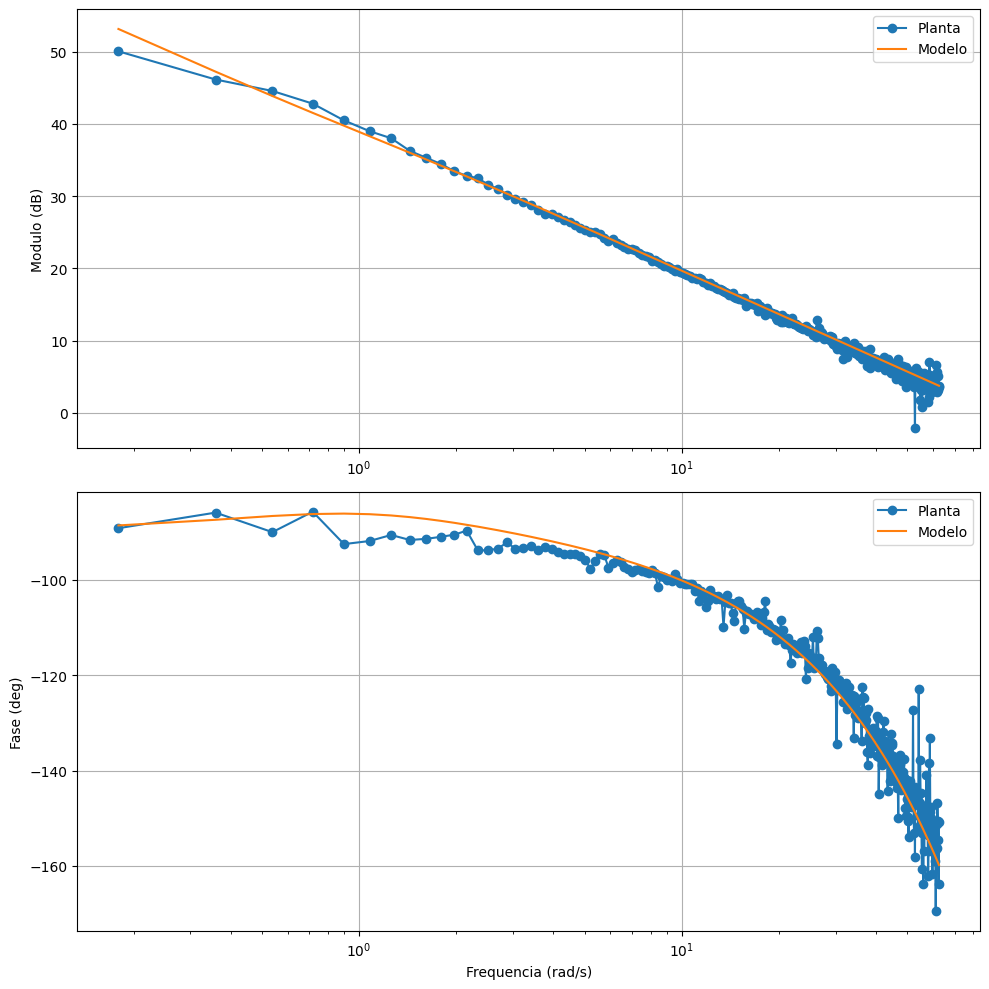

In [3]:
# Parâmetros do modelo com compensador
Ixx = 0.016 # Momento de inercia
tau = 0.0195 # Atraso de tempo

# Projeto do compensador de avanço de fase
fm = 1.7e-1 # Frequencia média em Hz
Gc = 3      # Ganho do compensador em dB
phim = 5.0  # Avanço de fase em graus na frequencia média
a, T, k = calcula_param_comp_avan(fm, Gc, phim)

mod_tf_dB, tf_fase = G_bode(freq_rad, lambda w: G(w, Ixx, tau, a, T, k))

print('a:', a)
print('T:', T)
print('k:', k)
print('Ixx:', Ixx)
print('tau:', tau)
    
# Gráfico de Bode
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.semilogx(freq_rad, modulo_dB, label='Planta', marker='o')
ax1.semilogx(freq_rad, mod_tf_dB, label='Modelo')
ax1.grid()
ax1.set_ylabel('Modulo (dB)')
ax1.legend()
ax2.semilogx(freq_rad, fase_deg, label='Planta', marker='o')
ax2.semilogx(freq_rad, np.unwrap(tf_fase), label='Modelo')
ax2.grid()
ax2.set_ylabel('Fase (deg)')
ax2.set_xlabel('Frequencia (rad/s)')
ax2.legend()
plt.tight_layout()
plt.show()

# Análise do modelo linear

O protótipo do modelo linear identificado para $P(s)$ é:
$$
\dfrac{P(s)}{U(s)}=Ke^{-\tau s}\left(\dfrac{s+a}{s+b}\right)\left(\dfrac{1}{s}\right).
$$
com $K$, $\tau$, $a$ e $b$ como parâmetros livres para otimização. Assim, temos: 
$$
s(s+a)P(s)=Ke^{-\tau s}(s+b)U(s)
$$
$$
s^2P(s)+asP(s)=Ke^{-\tau s}\left(sU(s)+bU(s)\right).
$$
Aplicando Transformada Inversa de Laplace, obtemos:
$$
\ddot{p}(t)+a\dot{p}(t)=K(\dot{u}(t-\tau)+bu(t-\tau)).
$$
Escolhendo como variáveis de estado $x_1(t)=p(t)$ e $x_2(t)=\dot{p}(t)$, temos;
$$
\begin{align*}
\dot{x}_1&=x_2\\
\dot{x}_2&=-ax_2+\hat{u},
\end{align*}
$$
onde $\hat{u}(t):=K(\dot{u}(t-\tau)+bu(t-\tau))$. 

A relação dos parâmetros do prtótipo com o modelo original é a seguinte $T=1/a$, $\alpha=a/b$, $aK/b=k/I_{xx}$.

# Ajuste dos parâmetros do modelo proposto
**Objetivo**: 

* Ajustar os parâmetros do modelo utilizando mínimos quadrados com os dados de referência. 
* Para isso utlizamos os mesmos dados utilizados para gerar a resposta em frequência

Precisamos dos dados:

1. Carregar dados dos arquivs txt,
2. Recortar os dados,
3. Ajustamos os dados utilizando mínimos quadrados.

---

1. Carregar dados dos arquivs txt.

In [4]:
# carregamos os dados de 'dados/t_controle.txt', que contém o tempo de controle
df_t_controle = pd.read_csv('dados/t_controle.txt')
t_controle = df_t_controle.iloc[:, 0].astype(float).to_numpy()
# carregamos os dados de 'dados/controle.txt', que contém o sinal de controle
df_controle = pd.read_csv('dados/controle.txt')
controle = df_controle.iloc[:, 0].astype(float).to_numpy()
# carregamos os dados de 'dados/vav0.txt', que contém a velocidade angular de rolagem
df_vav0 = pd.read_csv('dados/vav0.txt')
vav0 = df_vav0.iloc[:, 0].astype(float).to_numpy()

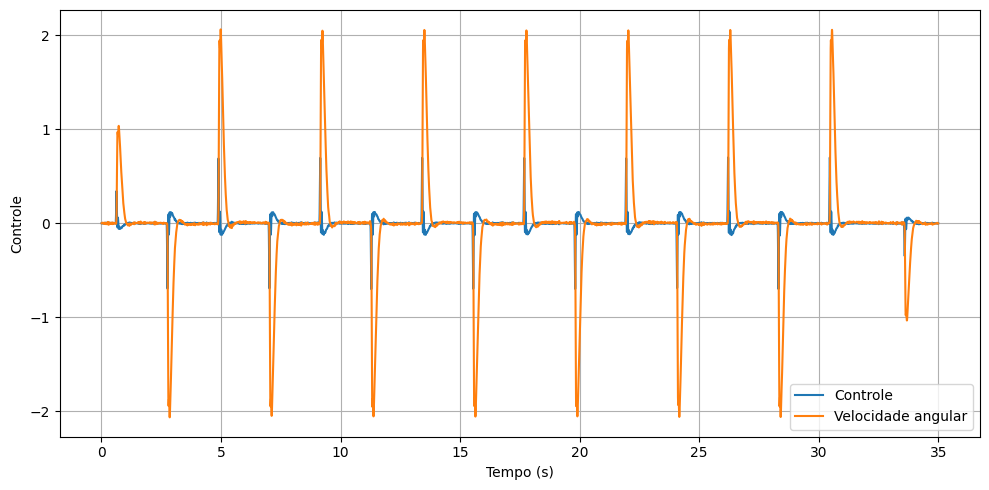

In [6]:
# plotamos os dados
plt.figure(figsize=(10, 5))
plt.plot(t_controle, controle, label='Controle')
plt.plot(t_controle, vav0, label='Velocidade angular')
plt.grid()
plt.xlabel('Tempo (s)')
plt.ylabel('Controle')
plt.legend()
plt.tight_layout()
plt.show()

2. Recortar os dados.

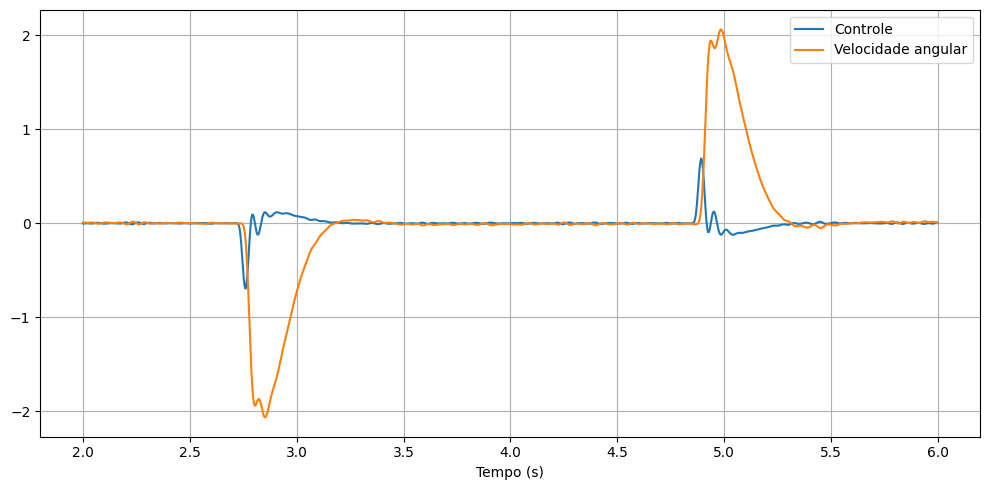

In [7]:
# recortamos os sinais
t0 = 2
tf = 6
dt = t_controle[1] - t_controle[0]
n0 = int(t0/dt)
nf = int(tf/dt)
t_controle_clipped = t_controle[n0:nf]
controle_clipped = controle[n0:nf]
vav0_clipped = vav0[n0:nf]
#
# plotamos os dados recortados
plt.figure(figsize=(10, 5))
plt.plot(t_controle_clipped, controle_clipped, label='Controle')
plt.plot(t_controle_clipped, vav0_clipped, label='Velocidade angular')
plt.grid()
plt.xlabel('Tempo (s)')
plt.legend()
plt.tight_layout()
plt.show()

3. Ajustamos os dados utilizando mínimos quadrados.

Aplicamos o método dos mínimos quadrados para ajustar os parâmetros do modelo para representar o melhor possível os dados obtido a partir do experimento.

Passos:
1. Preparar o sinal de entrada.
2. Preparar a ODE que representa o modelo e a função para a minimização
3. Escolher os valores mínimos e máximos dos parâmetros e o chute inicial.
4. Ajustar os parâmetros do método dos mínimos quadrados.
5. Rodar a otimização.
6. Verificar o resultado.
7. Se satisfeito, salvar os parâmetros.
---

1. Preparar o sinal de entrada $\hat{u}(t):=K(\dot{u}(t-\tau)+bu(t-\tau))$.

In [120]:
dcontrole = np.gradient(controle_clipped, dt)
# filtrar a derivada do sinal de controle
fc = 100 # (Hz) frequência de corte da derivada do sinal de controle.
dcontrole_filt = butter_lowpass_filter(dcontrole, fc, 1/dt)

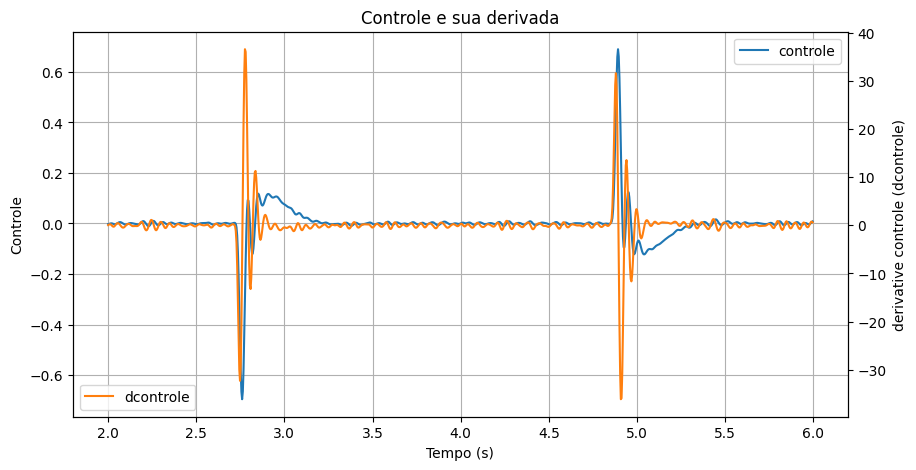

In [121]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(t_controle_clipped, controle_clipped, label='controle', color='tab:blue')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle e sua derivada')
ax1.legend(loc='upper right')
ax1.grid()
#
ax2 = ax1.twinx()
ax2.plot(t_controle_clipped, dcontrole_filt, label='dcontrole', color='tab:orange')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('derivative controle (dcontrole)')
ax2.legend(loc='lower left')
plt.show()

In [139]:
# interpolação do sinal de controle
controle_interp = interp1d(t_controle_clipped, controle_clipped, kind='linear', fill_value='extrapolate')
#dcontrole_interp = interp1d(t_controle_clipped, dcontrole_filt, kind='linear', fill_value='extrapolate') # A derivada do sinal de controle foi filtrada
dcontrole_interp = interp1d(t_controle_clipped, dcontrole, kind='linear', fill_value='extrapolate')  # A derivada do sinal de controle não foi filtrada
# 
# Sinal de controle u_hat(t)
def u_hat(t, tau, K, b):
    return K*(dcontrole_interp(t-tau) + b*controle_interp(t-tau))

2. Preparar a ODE que representa o modelo e a função para a minimização
$$
\begin{align*}
\dot{x}_1&=x_2\\
\dot{x}_2&=-ax_2+\hat{u},
\end{align*}
$$

In [140]:
# definição da ODE
def ode_p(t, x, tau, K, a, b):
        
    dx = np.zeros(2)
    dx[0] = x[1]
    dx[1] = -a*x[1] + u_hat(t, tau, K, b) 
    return dx

# Definição da função f para otimização
def f(tempo, tau, K, a, b):   
     
    p0 = vav0_clipped[0] # Condição inicial 
    x0 = np.array([p0, 0]) # Condição inicial
    func = lambda t, x: ode_p(t, x, tau, K, a, b)
    t0 = tempo[0]
    tf = tempo[-1]
    h = tempo[1] - tempo[0]
    _, x =  rk4(func, x0, t0, tf, h)
    return x[:, 0]

3. Escolher os valores mínimos e máximos dos parâmetros $\tau$, $K$, $a$ e $b$.

In [146]:
# valores de referência
#Ixx = 0.016 # Momento de inercia
#tau = 0.0195 # Atraso de tempo

tau_min = 0.019
tau_max = 0.020
K_min   = 60
K_max   = 120
a_min = 0.1
a_max = 10.0
b_min = 0.1
b_max = 10.0

param_min = [tau_min, K_min, a_min, b_min]
param_max = [tau_max, K_max, a_max, b_max]
bounds = (param_min, param_max)

# 
# Parâmetros iniciais
tau_0 = uniform(tau_min, tau_max)
K_0 = uniform(K_min, K_max)
a_0 = uniform(a_min, a_max)
b_0 = uniform(b_min, b_max)

#
p0 = [tau_0, K_0, a_0, b_0]

4. Ajustar os parâmetros do método dos mínimos quadrados.

In [147]:
# Parâmetros para a otimização
sigma = None
absolute_sigma = False
# checar se ha algum NaN ou InF nos dados
check_finite = True
# método de otimização (escolher um deles)
# ‘dogbox’ : dogleg algorithm with rectangular trust regions,
# 'trf' : Trust Region Reflective algorithm
method = 'trf'
# Jacobiano
jac = None

5. Rodar a otimização.

In [148]:
popt, pvoc = optimize.curve_fit(f, t_controle_clipped, vav0_clipped, p0, sigma, absolute_sigma, check_finite, bounds, method, jac)
perr = np.sqrt(np.diag(pvoc))

In [149]:
#print('popt =',popt)
print('tau (fitted) =',popt[0])
print('K (fitted) =',popt[1])
print('a (fitted) =',popt[2])
print('b (fitted) =',popt[3])
print('perr =',perr)

tau (fitted) = 0.019000000000000003
K (fitted) = 93.26815092747628
a (fitted) = 9.999999999999998
b (fitted) = 9.999999999999952
perr = [9.74717076e-05 2.00848105e-01 2.62864566e-01 2.65210100e-01]


6. Verificar o resultado.

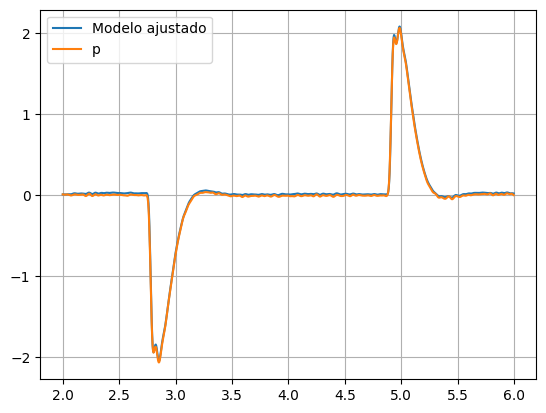

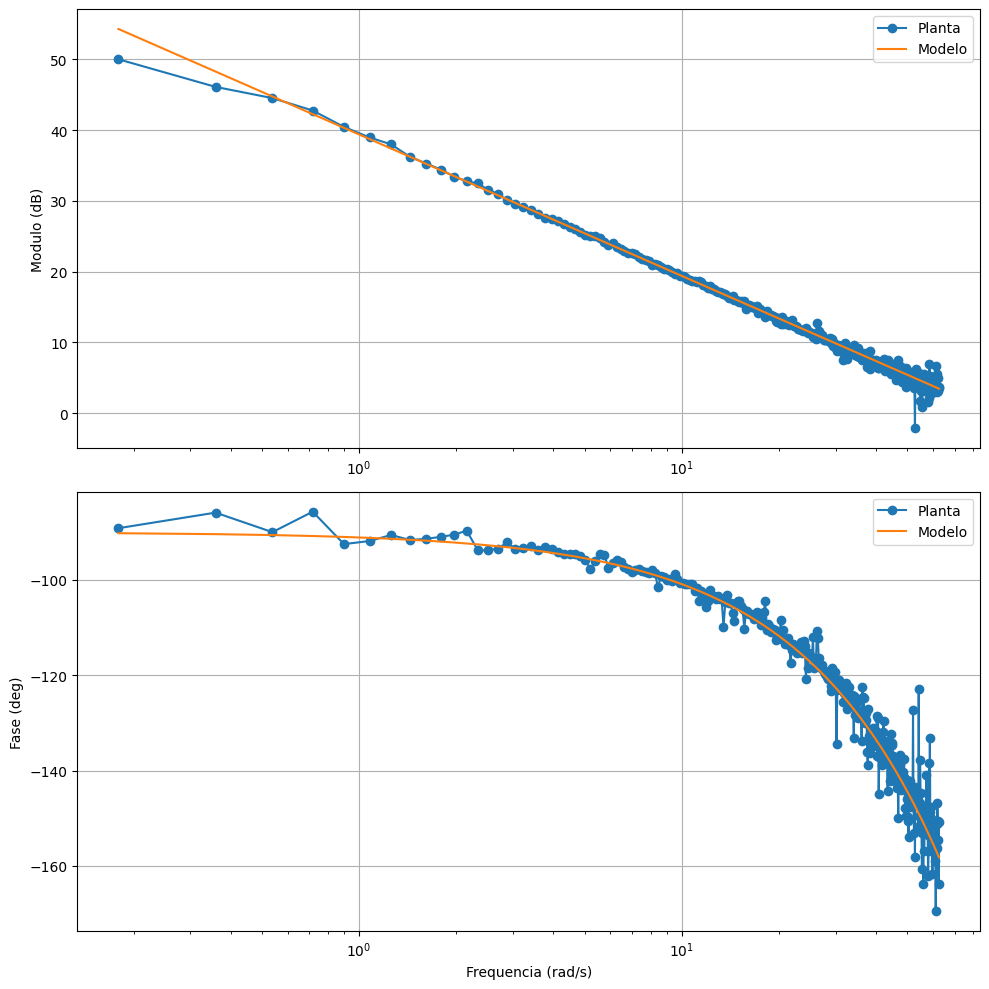

In [150]:
tau_fitted = popt[0]
K_fitted = popt[1]
a_fitted = popt[2]
b_fitted = popt[3]

plt.plot(t_controle_clipped, f(t_controle_clipped, tau_fitted, K_fitted, a_fitted, b_fitted), label='Modelo ajustado')
plt.plot(t_controle_clipped, vav0_clipped, label='p')
plt.legend()
plt.grid()
plt.show()

mod_tf_dB, tf_fase = G_bode(freq_rad, lambda w: G(w, 
                                                  Ixx=b_fitted/(a_fitted*K_fitted), 
                                                  tau=tau_fitted, 
                                                  alpha=a_fitted/b_fitted, 
                                                  T=1/a_fitted, 
                                                  k=1))

# Gráfico de Bode
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.semilogx(freq_rad, modulo_dB, label='Planta', marker='o')
ax1.semilogx(freq_rad, mod_tf_dB, label='Modelo')
ax1.grid()
ax1.set_ylabel('Modulo (dB)')
ax1.legend()
ax2.semilogx(freq_rad, fase_deg, label='Planta', marker='o')
ax2.semilogx(freq_rad, np.unwrap(tf_fase), label='Modelo')
ax2.grid()
ax2.set_ylabel('Fase (deg)')
ax2.set_xlabel('Frequencia (rad/s)')
ax2.legend()
plt.tight_layout()
plt.show()

7. Se satisfeito, salvar os parâmetros.

In [155]:
# salvar os parâmetros
#parametros = {
#    'tau': tau_fitted,
#    'K': K_fitted,
#    'a': a_fitted,
#    'b': b_fitted
#}
#
#with open('p_rate_parametros.pkl', 'wb') as f:
#    pickle.dump(parametros, f)